In [1]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt

EPS = 1e-12

def get_freq(N):
    arr = np.zeros((N,))
    arr[0:int(N-np.floor(N/2))] = np.array(range(0,int(N-np.floor(N/2))))
    arr[int(N-np.floor(N/2)):N] = np.array(range(0,int(np.floor(N/2)))) - np.floor(N/2)
    return arr

In [211]:
def get_mu(M,leng):
    arr = np.zeros((M,))
    arr[0:int(M-np.floor(M/2))] = np.array(range(0,int(M-np.floor(M/2))))
    arr[int(M-np.floor(M/2)):M] = np.array(range(0,int(np.floor(M/2)))) - np.floor(M/2)
    return 2*np.pi*arr/leng
#This code is given by the scheme of Bao Du, so it is intended to translate the Bao Du paramaters to the
#other ones. I mean, if the value of beta you have is calculated for a given epsilon, not 1, 
#then you are expected to divide it by eps^{5/2}


def td_tssp_2d_pbc_bis(M, time_steps, a, b, c, d, psi0, potential, dt, beta, eps, saving_time):

    x = np.linspace(a, b, M, endpoint=False)
    y = np.linspace(c, d, M, endpoint=False)
    X, Y = np.meshgrid(x, y, sparse=False, indexing="ij")
    t = dt * np.arange(time_steps)
    mux = get_mu(M,b-a)
    muy = get_mu(M,d-c)

    Mux, Muy = np.meshgrid(mux, muy, sparse=False, indexing="ij")
    Mu2 = Mux**2 + Muy**2

    psi = np.empty((int(time_steps/saving_time), M, M), dtype=complex)
    psi[0,:] = psi0(X, Y)
    
    V = potential(X, Y) / eps
    zero_pot = (np.abs(V) < EPS).astype(int)
    expV = np.exp(- dt * V )

    p = psi[0,:]

    for i in range(1, time_steps): #Here I divided beta/eps as I think it was necessary for the eq to be valid for eps!=1
        p= _td_tssp_pbc_2d_step_bis(p, dt, beta/eps, eps, x[2]- x[1], y[2]- y[1], \
                                        V, expV, zero_pot, Mu2)
        if i%saving_time==0:
            psi[int(i/saving_time),:] = p
    return t, X, Y, psi



def _td_tssp_pbc_2d_step_bis(psi, dt, beta, eps, dx, dy, V, expV, zero_pot, Mu2):

    abs_psi = np.abs(psi)**2
    p1 = np.empty(psi.shape, dtype=complex)
    p1 = psi * np.where(zero_pot, 1 / np.sqrt(1 + beta*dt * abs_psi), \
                        np.sqrt((V*expV) / (V + beta*(1 - expV)*abs_psi)) )

    p2 = fft.ifft2(fft.fft2(p1) * np.exp(- eps*dt * Mu2 /2))

    abs_p2 = np.abs(p2)**2
    p3 = np.empty(psi.shape, dtype=complex)
    p3 = p2 * np.where(zero_pot, 1 / np.sqrt(1 + beta*dt * abs_p2), \
                        np.sqrt((V*expV) / (V + beta*(1 - expV)*abs_p2)))

    return p3 / np.sqrt(dx*dy * np.sum(np.abs(p3)**2))

def gradient_2d(psi, x_spacing, y_spacing):
    g = np.empty((2, psi.shape[0], psi.shape[1]), dtype=psi.dtype)
    g[0,:] = (np.roll(psi, 1, axis=0) - psi)/x_spacing
    g[1,:] = (np.roll(psi, 1, axis=1) - psi)/y_spacing
    return g
def veloc_2d(psi,x_spacing,y_spacing):
    v = np.empty((2, psi.shape[0], psi.shape[1]), dtype=psi.dtype)
    zero_abs = (np.abs(psi)**2 < EPS).astype(int)
    v = np.where(zero_abs,0,gradient_2d(psi,x_spacing,y_spacing)*np.conj(psi)-psi*gradient_2d(np.conj(psi),x_spacing,y_spacing))/(1j*np.abs(psi)**2)
    return v

def mean_value_bis(f, psi, a, b, c, d, M):
    dA = (b-a)*(d-c)/(M**2)

    x = np.linspace(a, b, M,endpoint=False)
    y = np.linspace(c, d, M,endpoint=False)
    X, Y = np.meshgrid(x, y, sparse=False, indexing="ij")
    
    return np.sum(f(X,Y) * np.abs(psi)**2)* dA

def energy_gpe(psi, V, beta,eps, x_spacing, y_spacing):#Here we have to use eps to rescale beta, and the potential but also the part with the gradient 
    a = np.abs(psi)
    g = gradient_2d(psi, x_spacing, y_spacing)
    g2 = np.abs(g[0,:])**2 + np.abs(g[1,:])**2
    return x_spacing*y_spacing * np.sum(0.5*g2*eps + V * a**2/eps + 0.5*beta * a**4/eps)
def mu_gpe(psi, V, beta,eps, x_spacing, y_spacing):#Here we have to use eps to rescale beta, and the potential but also the part with the gradient 
    a = np.abs(psi)
    g = gradient_2d(psi, x_spacing, y_spacing)
    g2 = np.abs(g[0,:])**2 + np.abs(g[1,:])**2
    return x_spacing*y_spacing * np.sum(0.5*g2*eps + V * a**2/eps + beta * a**4/eps)

fx= lambda x,y: x
fy= lambda x,y: y
fx2= lambda x,y: x**2
fy2= lambda x,y: y**2

In [214]:
M=256
N=5000
a=-10
b=10
c=-10
d=10
gx=1
gy=1
v=2
w0, delt, r0 = 60, 3,0
potential=lambda x,y:(gx**2*x**2+gy**2*y**2)/2 + w0*np.exp(-delt*((x-r0)**2+y**2)) #notice that the potential is 1/2 instead of 1/4, maybe can discusse it later in more detail 
potential_t=lambda x,y,t:(gx**2*x**2+gy**2*y**2)/2 + w0*np.exp(-delt*((x-r0)**2+(y-v*t)**2))
psi0= lambda x,y: (gx*gy)**(1/4)*np.exp(-(gx**2*x**2+gy**2*y**2)/2)/np.pi**(1/2)

dt=0.001
saving_time=4999
eps=2
beta=1000 #Notice that I put twice the value in the paper as later it is diveided by epsilon

In [215]:
t, X, Y, psi=td_tssp_2d_pbc_bis(M, N, a, b, c, d, psi0, potential, dt, beta, eps,saving_time)

IndexError: index 1 is out of bounds for axis 0 with size 1

<IPython.core.display.Javascript object>


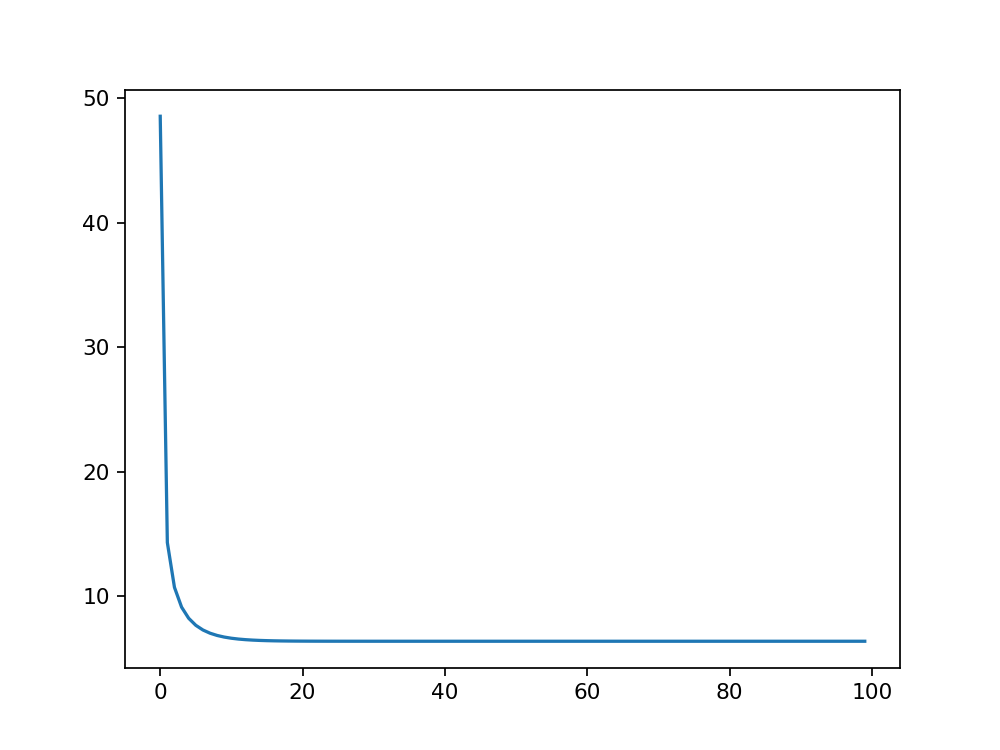

NameError: name 'bet' is not defined

In [138]:

V = potential(X, Y)
x_spacing=(b-a)/M
y_spacing=(d-c)/M

En = np.empty(len(psi))
for i in range (len(psi)):
    En[i]=energy_gpe(psi[i], V, beta,eps, x_spacing, y_spacing)
plt.figure()
plt.plot(En)
plt.show()

mu_g = mu_gpe(psi[-1],V,bet/a,eps,x_spacing,y_spacing)

x_rms = np.sqrt(mean_value_bis(fx2,psi[-1],a,b,c,d,M))
y_rms = np.sqrt(mean_value_bis(fy2,psi[-1],a,b,c,d,M))

print('x_rms={:.5}'.format(x_rms))
print('y_rms={:.4}'.format(y_rms))
print('E_g={:.6}'.format(En[-1]))
print('mu_g={:.6}'.format(mu_g))

In [6]:
mu_g/2

4.521520517529787

<IPython.core.display.Javascript object>


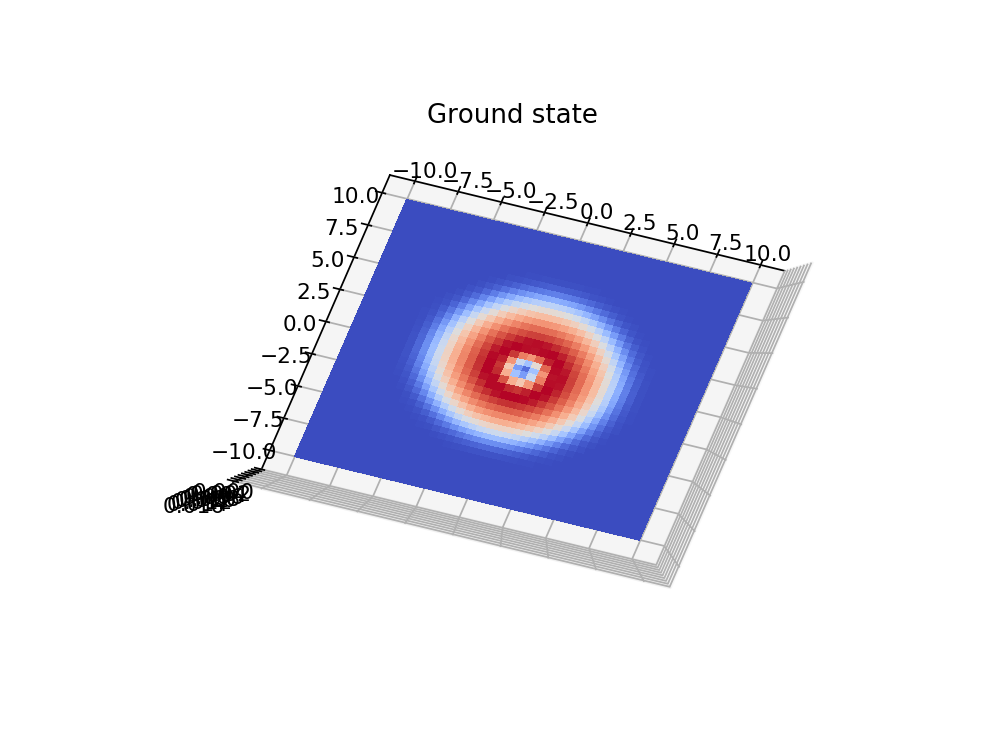

In [116]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

psi2=np.abs(psi)**2
zmax=np.max(psi2[-1])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_zlim3d(0, zmax)
ax.set_title("Ground state")

surf = ax.plot_surface(X, Y, psi2[-1], cmap=cm.coolwarm,
                   linewidth=0, antialiased=False)

<IPython.core.display.Javascript object>


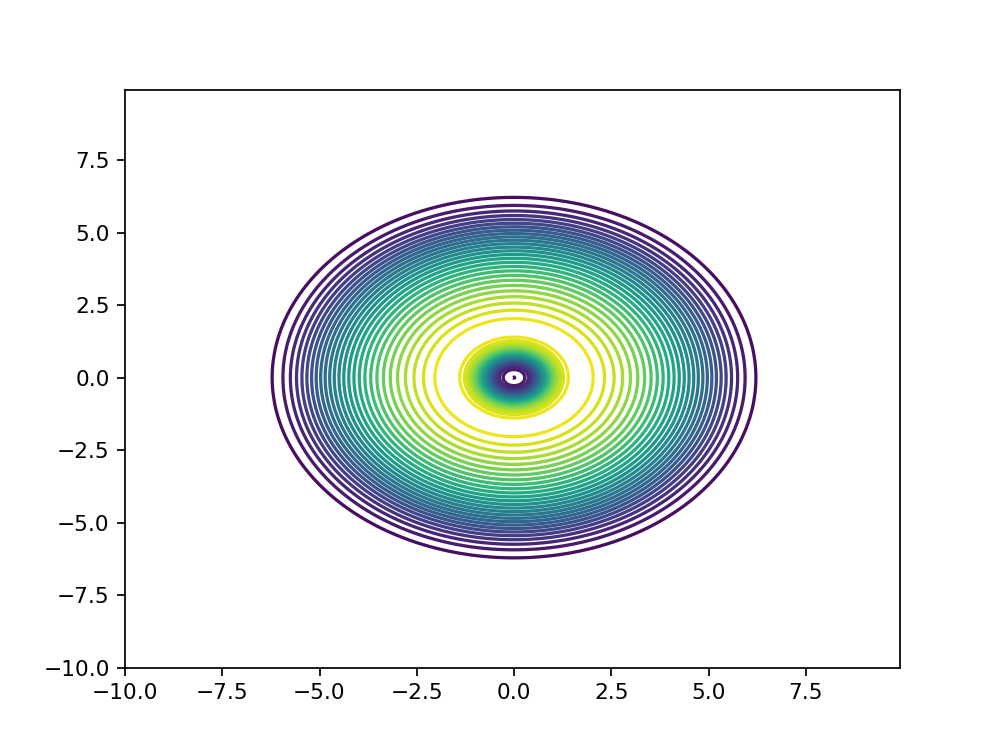

In [139]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

psi2=np.abs(psi)**2
zmax=np.max(psi2[-1])

fig = plt.figure()
plt.contour(X,Y,psi2[-1],30,vmax=zmax)

In [140]:

def TSSP2D_opt(M,N,q,a,b,psi0,potential,dt,k1,eps):
    # 1/q is the fraction of the times we want to store. q must devide N
    
    n=int(N/q)
    x=np.linspace(a,b,M,endpoint=False)
    y=np.linspace(a,b,M,endpoint=False)
    x,y=np.meshgrid(x,y,sparse=False,indexing="ij")
    t=np.linspace(0,N*dt,n,endpoint=False)
    freq=get_freq(M)
    freqx,freqy=np.meshgrid(freq,freq,sparse=False,indexing="ij")
    
    psi=np.zeros((n,M,M),dtype=complex)
    psi[0,:]=psi0
    
    for i in range (1,n):
        ps = psi[i-1]
        
        ps = ps*np.exp(-1j*(potential(x,y,t[i])+k1*np.abs(ps)**2)*dt/(2*eps))
        ps = np.fft.ifft2(np.fft.fft2(ps)*np.exp(-1j*(eps/2)*dt*4*np.pi**2*(freqx**2+freqy**2)/(b-a)**2))
        
        for j in range(q-1):
        
            ps = ps*np.exp(-1j*(potential(x,y,t[i]+dt*j)+k1*np.abs(ps)**2)*dt/eps)

            ps = np.fft.ifft2(np.fft.fft2(ps)*np.exp(-1j*(eps/2)*dt*4*np.pi**2*(freqx**2+freqy**2)/(b-a)**2))
        
        psi[i] = ps*np.exp(-1j*(potential(x,y,t[i]+dt*j)+k1*np.abs(ps)**2)*dt/(2*eps))
        
    return t,x,y,psi

In [160]:
t,x,y,psi=TSSP2D_opt(M,7000,saving_time,a,b,psi[-1],potential_t,dt,beta,eps)

<IPython.core.display.Javascript object>


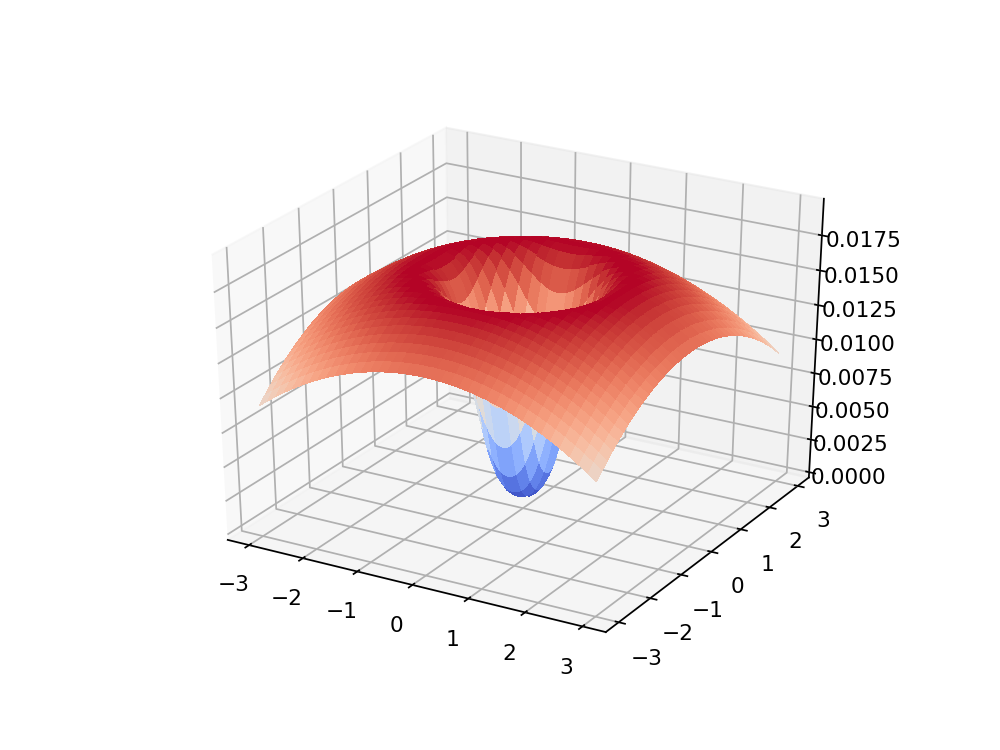

In [142]:

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.animation as animation

proba_density = np.abs(psi)**2

# To restrict the xy domain to the intesresting part for plot
xydomain = np.logical_and.reduce([x>-3, x<3, y>-3, y<3])
Mplot = int(np.sqrt(np.sum(xydomain))) # the new M for the restricted arrays ; np.sum(xydomain) should be a perfect square

xplot = np.reshape(x[xydomain],(Mplot,Mplot))
yplot = np.reshape(y[xydomain],(Mplot,Mplot))

psiplot = np.empty((len(proba_density), Mplot, Mplot))
for i in range(len(psiplot)):
    psiplot[i] = np.reshape(proba_density[i][xydomain],(Mplot,Mplot))

zmax=np.max(psiplot)

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

nstep = 100 # number of frames of the animation ; must be smaller than len(t)
m = 1.5 # 1/m is the fraction of the total time t.max that we want to plot

# The function to use for FuncAnimation
def step(s):
    ax.cla()
    ax.set_zlim3d(0, zmax)
    i=int((s*len(t)/nstep+1)/m)
    
    surf = ax.plot_surface(xplot, yplot, psiplot[i], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_title(r"$t={:.3}$".format(i*Dt))
   
animation.FuncAnimation(fig,step,nstep, interval=30,repeat=False)

<IPython.core.display.Javascript object>


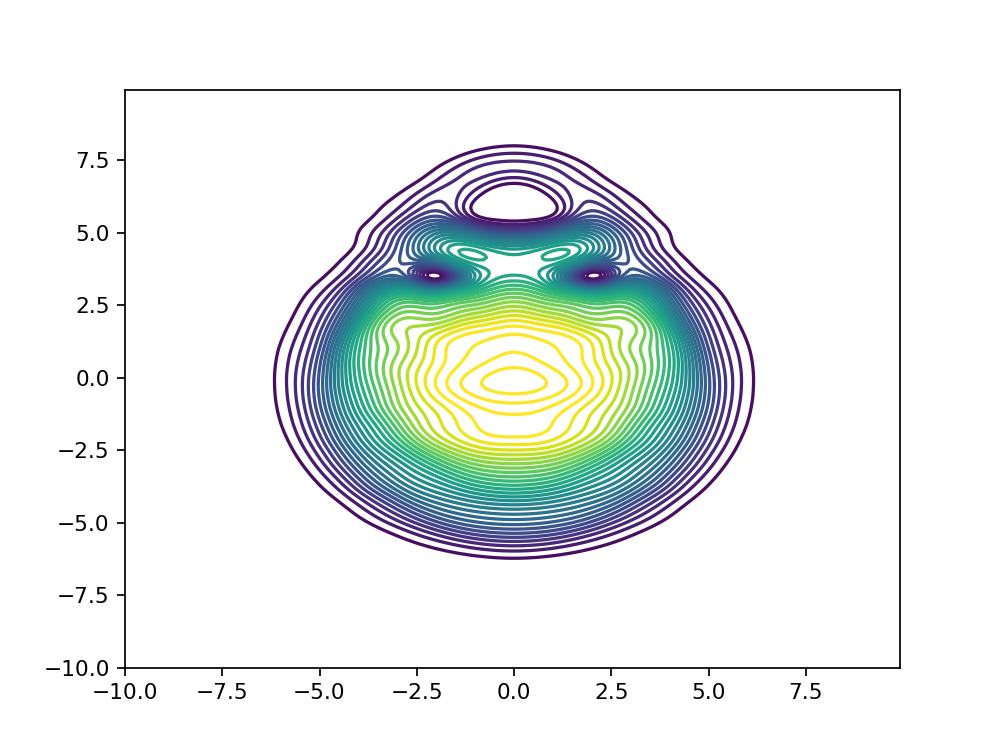

<IPython.core.display.Javascript object>


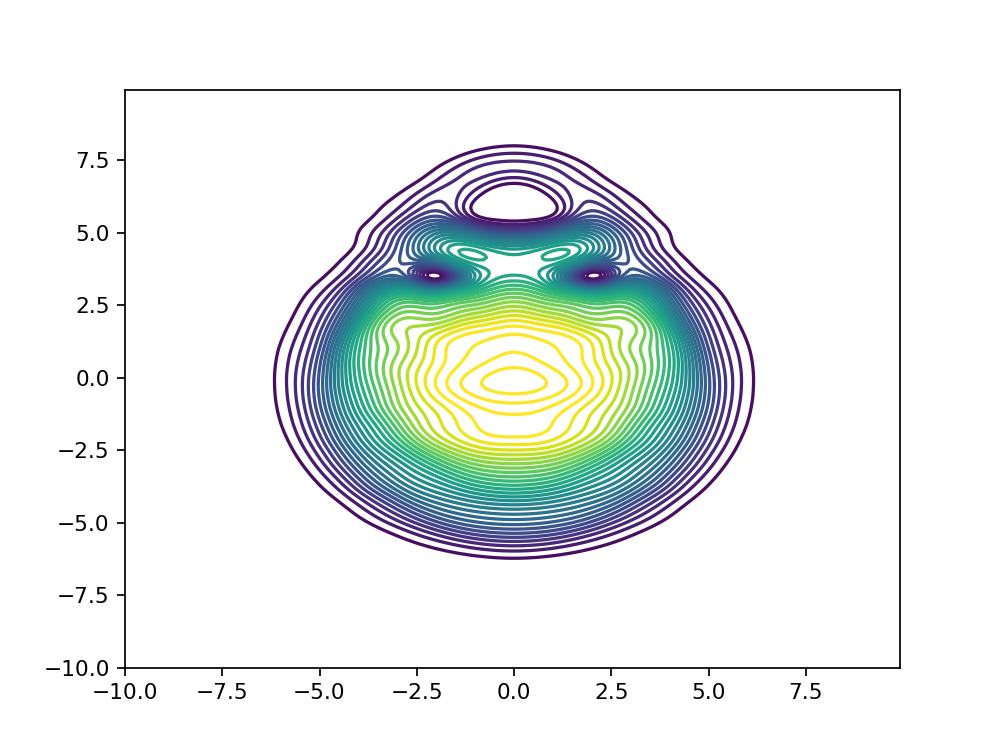

<IPython.core.display.Javascript object>


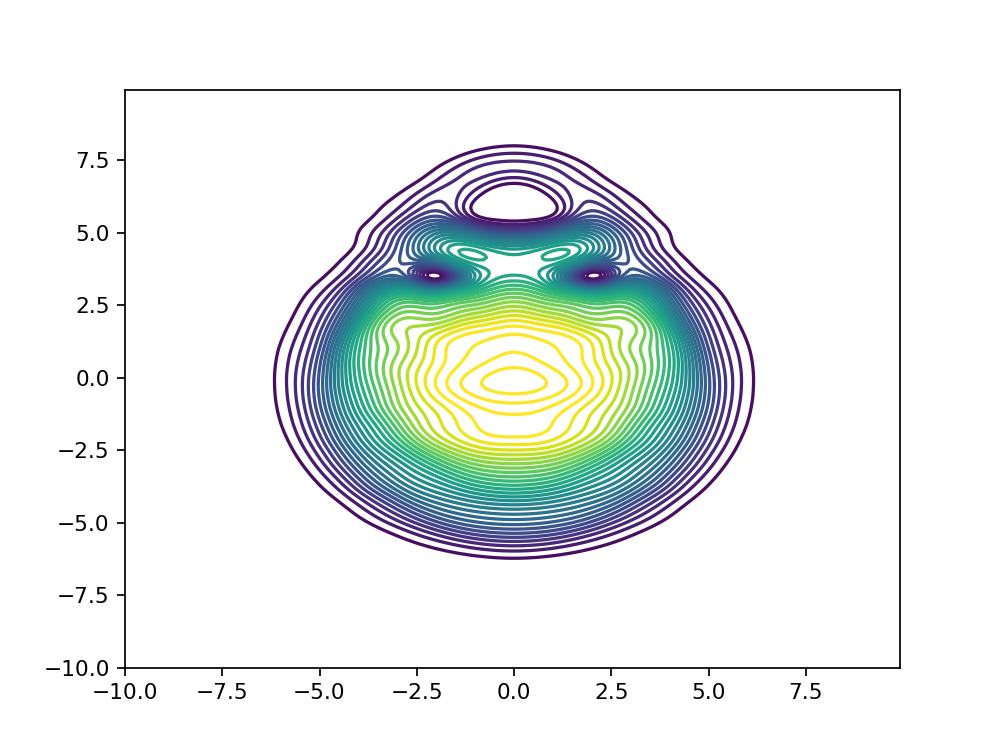

<IPython.core.display.Javascript object>


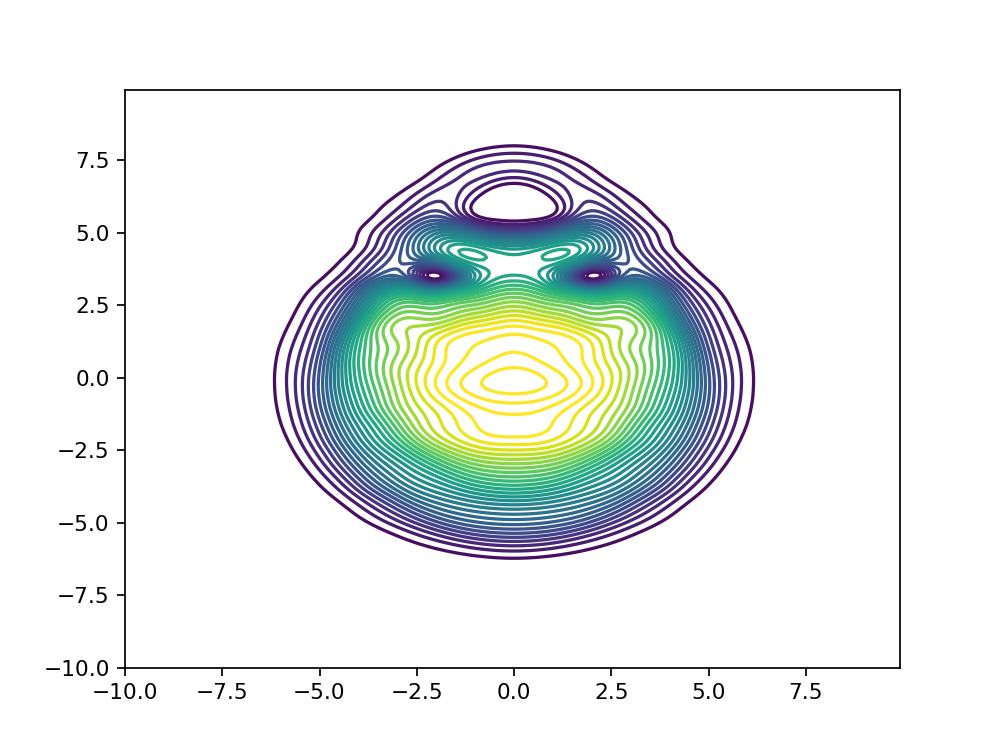

<IPython.core.display.Javascript object>


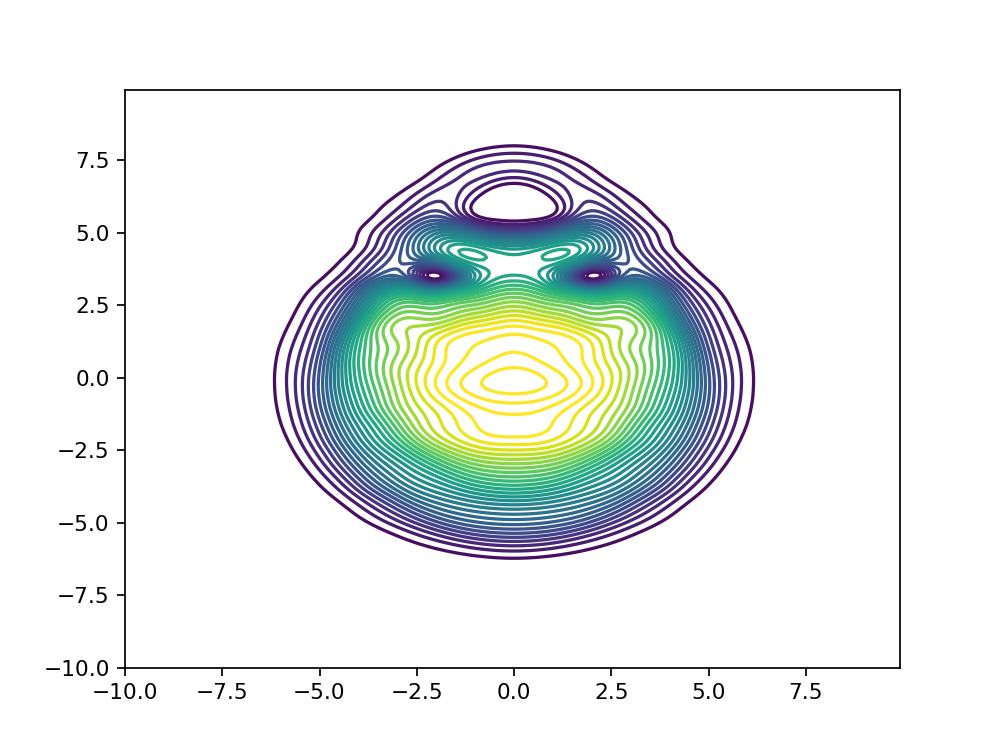

<IPython.core.display.Javascript object>


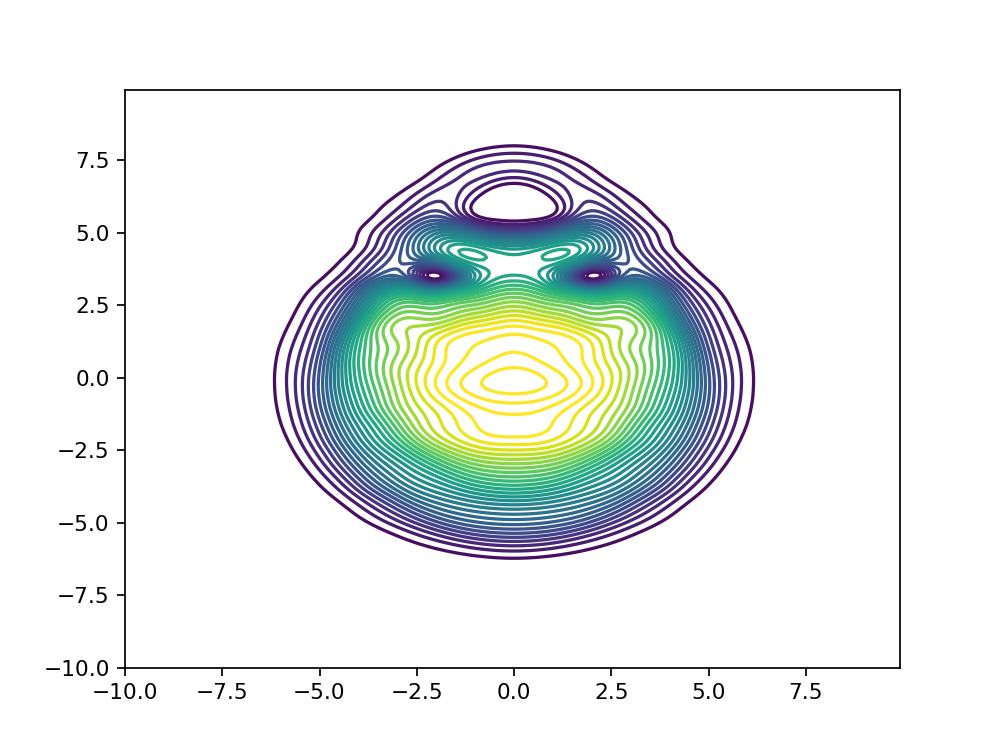

<IPython.core.display.Javascript object>


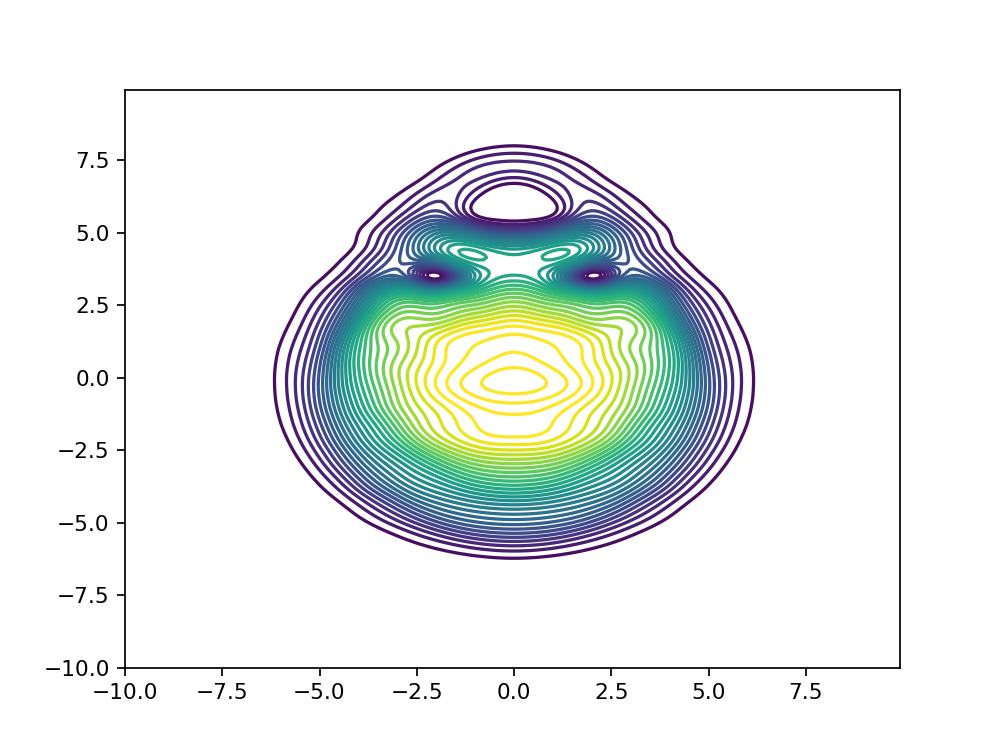

<IPython.core.display.Javascript object>


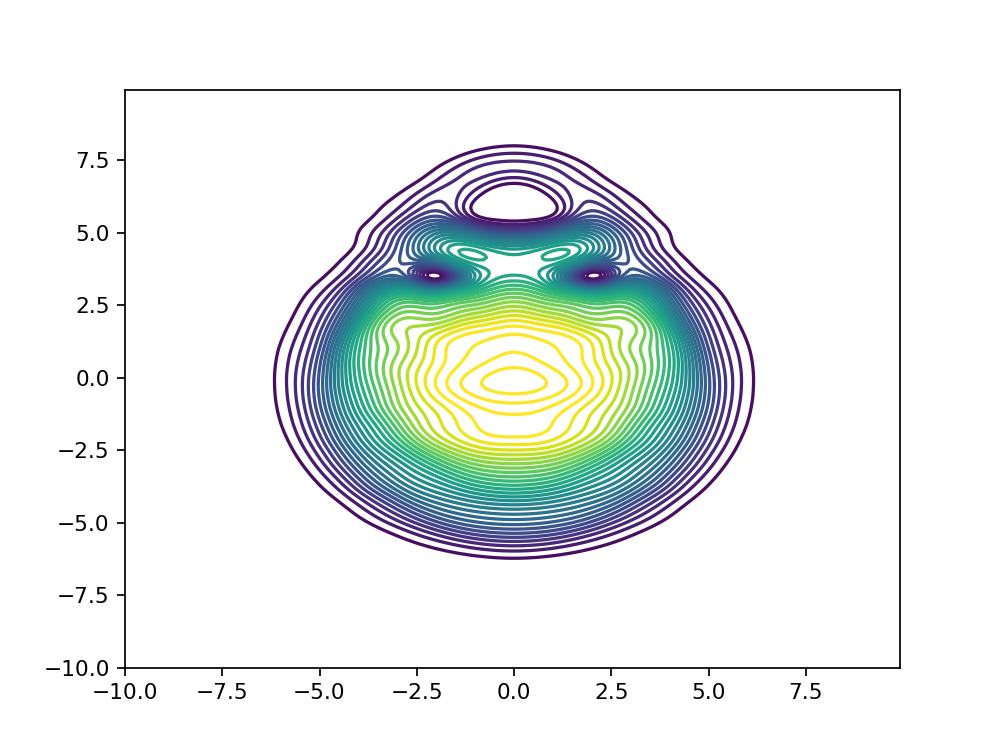

<IPython.core.display.Javascript object>


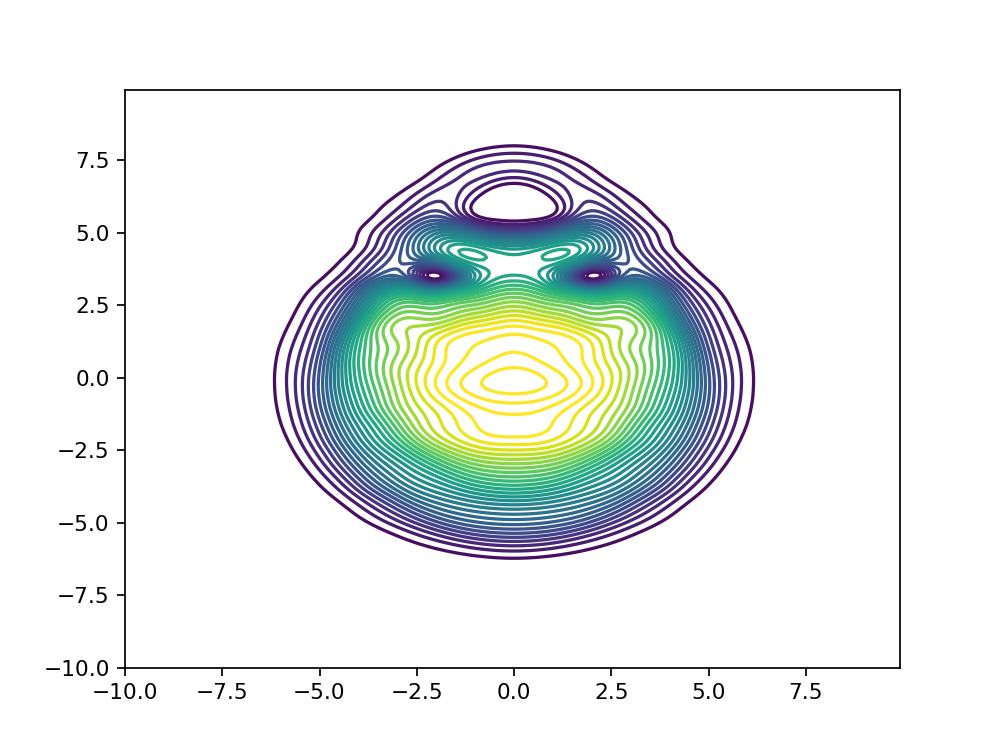

<IPython.core.display.Javascript object>


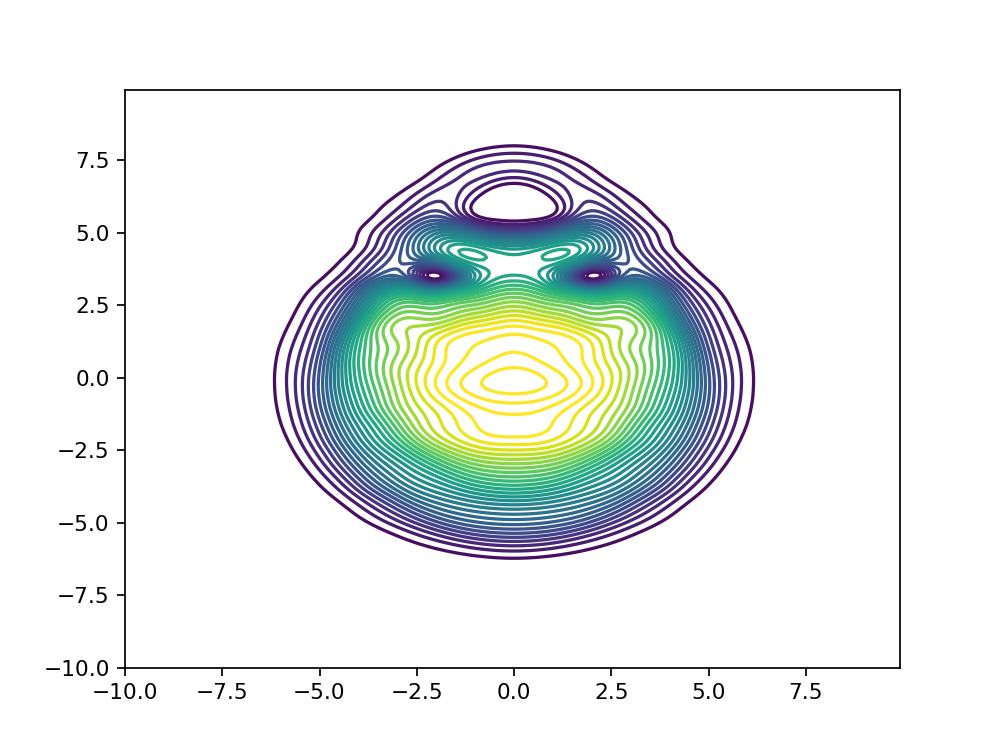

In [185]:
for i in range (10):
    psi2=np.abs(psi[59])**2
    zmax=0.016
    fig = plt.figure()
    plt.contour(X,Y,psi2,30,vmax=zmax)

In [81]:

M=16*8
N=10000
a=-8
b=8
c=-4
d=4
gx=1
gy=4
saving_time=50
potential=lambda x,y:(gx**2*x**2+gy**2*y**2)/2
psi0= lambda x,y: (gx*gy)**(1/4)*np.exp(-(gx**2*x**2+gy**2*y**2)/2)/np.pi**(1/2)
beta=200.
dt=0.001
eps=1

In [82]:
t, X, Y, psi=td_tssp_2d_pbc_bis(M, N, a, b, c, d, psi0, potential, dt, beta, eps,saving_time)

/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/home/lopetegui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


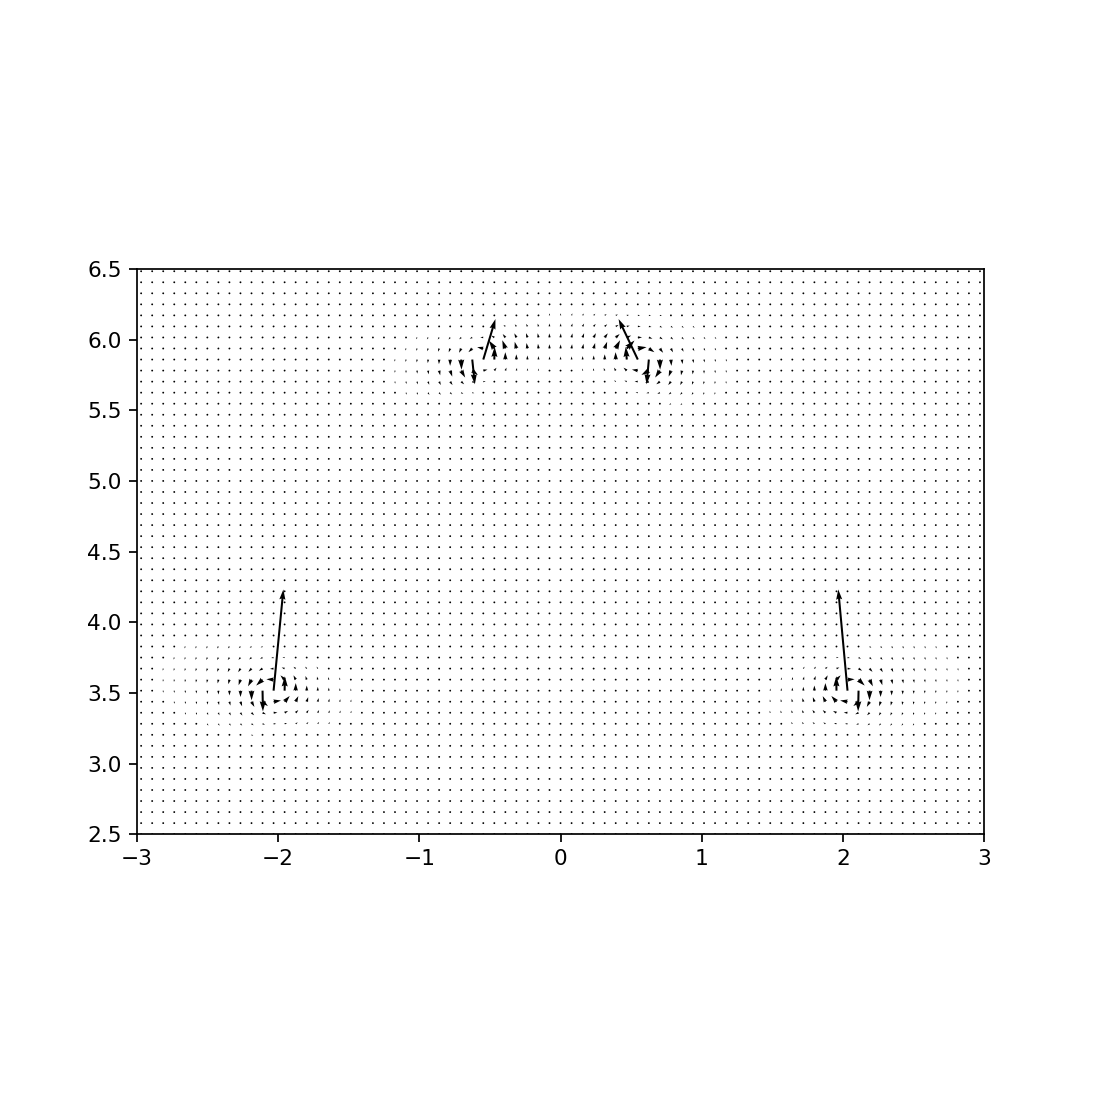

In [212]:
u,v=veloc_2d(psi[59],x_spacing,y_spacing) #t=59 given the saving_time we used is equivalent to t=2.95 I think, so, it is the most close we hahve to t=3

fig, ax = plt.subplots(figsize=(7,7))
ax.quiver(X,Y,u,v)
ax.axis([-3,3, 2.5,6.5])

ax.set_aspect('equal')

plt.show()#I will upgrade the graphic, sorry it is kind of basic still

In [224]:
X[1][0]-X[0][0]

0.078125